In [ ]:
# 1) PATHS & FOLDERS (ABSOLUTE) — updated to use reports/
from pathlib import Path

PROJECT_ROOT = Path("/home/shamil-suraweera/Documents/Horizon_Campus/IT41043-Intelligent_Systems/Assignment-1/mine/wine-quality-prediction").resolve()
DATA_PATH     = (PROJECT_ROOT / "data"    / "WineQT.csv").resolve()
ARTIFACTS_DIR = (PROJECT_ROOT / "models").resolve()
REPORTS_DIR   = (PROJECT_ROOT / "reports").resolve()   # 👈 plural

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PATH   :", DATA_PATH, "| exists:", DATA_PATH.exists())
print("ARTIFACTS   :", ARTIFACTS_DIR)
print("REPORTS_DIR :", REPORTS_DIR)


PROJECT_ROOT: /home/shamil-suraweera/Documents/Horizon_Campus/IT41043-Intelligent_Systems/Assignment-1/mine/wine-quality-prediction
DATA_PATH   : /home/shamil-suraweera/Documents/Horizon_Campus/IT41043-Intelligent_Systems/Assignment-1/mine/wine-quality-prediction/data/WineQT.csv | exists: True
ARTIFACTS   : /home/shamil-suraweera/Documents/Horizon_Campus/IT41043-Intelligent_Systems/Assignment-1/mine/wine-quality-prediction/models
REPORT_DIR  : /home/shamil-suraweera/Documents/Horizon_Campus/IT41043-Intelligent_Systems/Assignment-1/mine/wine-quality-prediction/report


In [2]:
# 2) IMPORTS & SEED
import warnings, math, json
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import (
    train_test_split, RepeatedStratifiedKFold, RepeatedKFold, cross_validate
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC

# metrics
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    r2_score, mean_absolute_error, mean_squared_error,
    precision_recall_curve, roc_curve, RocCurveDisplay, auc
)

from joblib import dump, load

np.random.seed(42)
print("Imports OK.")


Imports OK.


In [3]:
# 3) LOAD CSV (ABSOLUTE)
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset missing at:\n{DATA_PATH}")

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
display(df.dtypes)
print("Missing values per column:")
display(df.isna().sum().sort_values(ascending=False))


Shape: (1143, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
Id                        int64
dtype: object

Missing values per column:


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1143.0,8.311111,1.747595,4.60000,7.10000,7.90000,9.100000,15.90000
volatile acidity,1143.0,0.531339,0.179633,0.12000,0.39250,0.52000,0.640000,1.58000
citric acid,1143.0,0.268364,0.196686,0.00000,0.09000,0.25000,0.420000,1.00000
residual sugar,1143.0,2.532152,1.355917,0.90000,1.90000,2.20000,2.600000,15.50000
chlorides,1143.0,0.086933,0.047267,0.01200,0.07000,0.07900,0.090000,0.61100
free sulfur dioxide,1143.0,15.615486,10.250486,1.00000,7.00000,13.00000,21.000000,68.00000
total sulfur dioxide,1143.0,45.914698,32.782130,6.00000,21.00000,37.00000,61.000000,289.00000
density,1143.0,0.996730,0.001925,0.99007,0.99557,0.99668,0.997845,1.00369
pH,1143.0,3.311015,0.156664,2.74000,3.20500,3.31000,3.400000,4.01000
sulphates,1143.0,0.657708,0.170399,0.33000,0.55000,0.62000,0.730000,2.00000


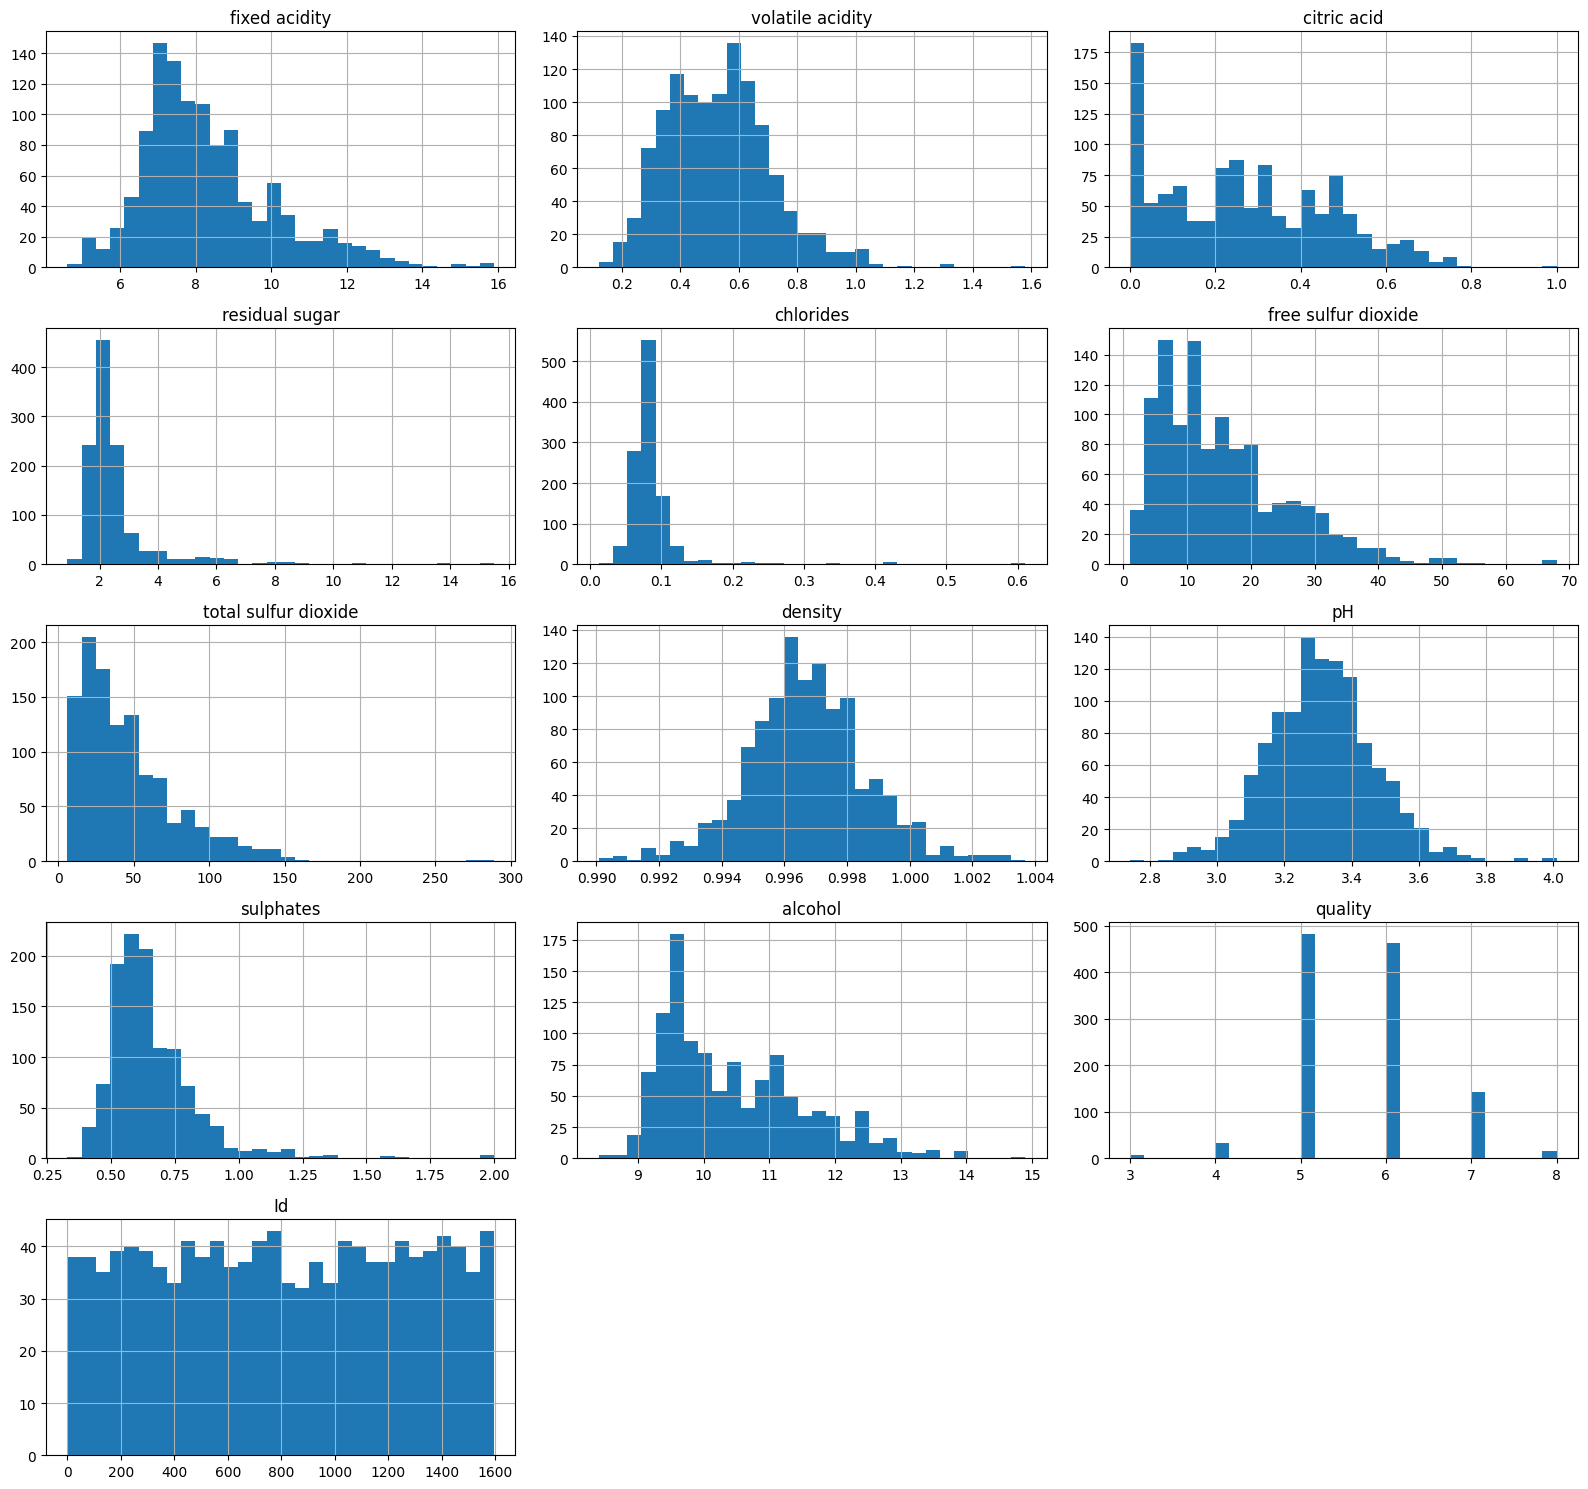

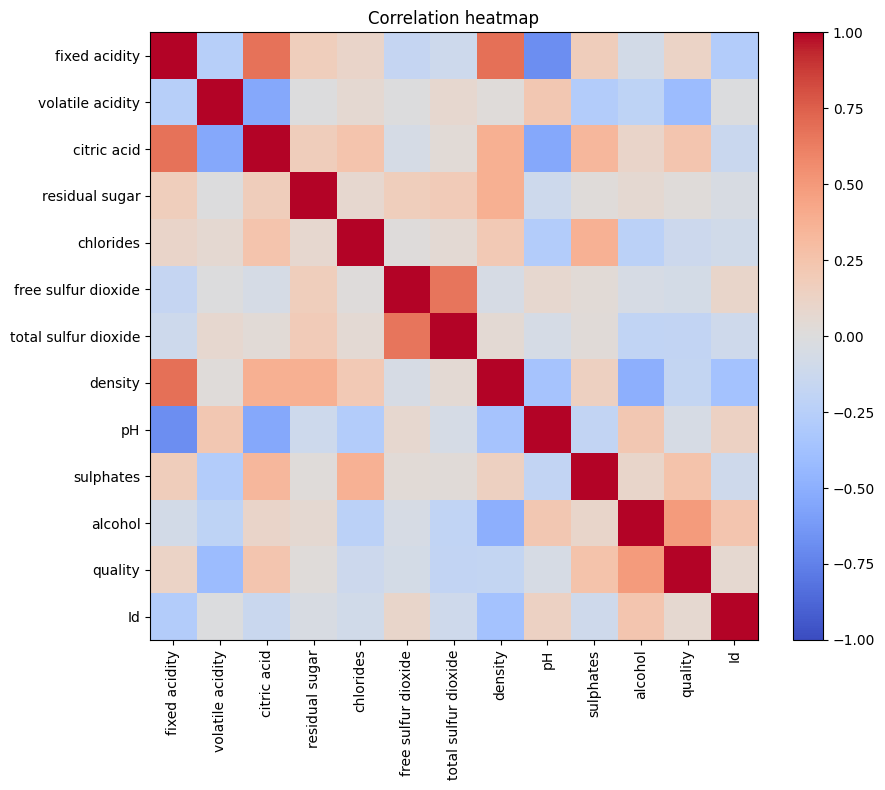

Top correlations with 'quality':


quality                 1.000000
alcohol                 0.484866
sulphates               0.257710
citric acid             0.240821
fixed acidity           0.121970
Id                      0.069708
residual sugar          0.022002
pH                     -0.052453
free sulfur dioxide    -0.063260
chlorides              -0.124085
density                -0.175208
total sulfur dioxide   -0.183339
volatile acidity       -0.407394
Name: quality, dtype: float64

In [4]:
# 4) EDA (QUICK)
num_df = df.select_dtypes(include=[np.number])
display(num_df.describe().T)

# histograms
num_cols = num_df.columns.tolist()
n = len(num_cols); ncols = 3; nrows = max(1, math.ceil(n/ncols))
plt.figure(figsize=(16, nrows*3))
for i, c in enumerate(num_cols, 1):
    plt.subplot(nrows, ncols, i)
    df[c].hist(bins=30)
    plt.title(c)
plt.tight_layout(); plt.show()

# correlations
corr = num_df.corr()
plt.figure(figsize=(10, 8))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation heatmap"); plt.tight_layout(); plt.show()

if "quality" in corr.columns:
    print("Top correlations with 'quality':")
    display(corr["quality"].sort_values(ascending=False))


In [5]:
# 5) TASK, TARGET, FEATURES
TASK_TYPE = "classification"   # "classification" or "regression"
CLASSIFICATION_MODE = "binary" # "binary" or "multiclass"
GOOD_THRESHOLD = 7

if "quality" not in df.columns:
    raise KeyError("Expected 'quality' column in dataset.")

df["quality"] = pd.to_numeric(df["quality"], errors="coerce")
if df["quality"].isna().any():
    raise ValueError("Non-numeric values detected in 'quality'.")

df_model = df.copy()

if TASK_TYPE.lower() == "classification":
    if CLASSIFICATION_MODE == "binary":
        df_model["target"] = (df_model["quality"] >= GOOD_THRESHOLD).astype(int)
        y = df_model["target"]
        print("Binary class counts:\n", y.value_counts().sort_index().to_string())
    else:
        y = df_model["quality"].astype(int)
        print("Multiclass counts:\n", y.value_counts().sort_index().to_string())
elif TASK_TYPE.lower() == "regression":
    y = df_model["quality"]
    display(y.describe())
else:
    raise ValueError("TASK_TYPE must be classification or regression.")

X = df_model.drop(columns=[c for c in ["Id", "quality", "target"] if c in df_model.columns])
print(f"X shape: {X.shape} | y shape: {y.shape}")
display(X.head())


Binary class counts:
 target
0    984
1    159
X shape: (1143, 11) | y shape: (1143,)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [6]:
# 6) TRAIN/TEST SPLIT
if TASK_TYPE.lower() == "classification":
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        stratified = True
    except ValueError as e:
        print("Stratify failed, falling back:", e)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        ); stratified = False
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    ); stratified = False

print(f"Train: {X_train.shape} | Test: {X_test.shape} | Stratified: {stratified}")


Train: (914, 11) | Test: (229, 11) | Stratified: True


In [7]:
# 7) PREPROCESS (IMPUTE + SCALE)
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
if not numeric_features:
    raise ValueError("No numeric features in X_train.")

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler(with_mean=True, with_std=True))
])

preprocessor = ColumnTransformer(
    [("num", numeric_transformer, numeric_features)],
    remainder="drop",
    verbose_feature_names_out=False
)
preprocessor.fit(X_train)
print("Numeric features:", numeric_features)


Numeric features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [8]:
# 8) CANDIDATES & PIPELINES
if TASK_TYPE.lower() == "classification":
    candidates = {
        "LogReg": LogisticRegression(max_iter=1000, random_state=42),
        "RF":     RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1),
        "GBC":    GradientBoostingClassifier(random_state=42),
        "SVC":    SVC(probability=True, random_state=42),
    }
else:
    candidates = {
        "LinReg": LinearRegression(),
        "Ridge":  Ridge(alpha=1.0),
        "RF":     RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
        "GBR":    GradientBoostingRegressor(random_state=42),
    }

pipelines = {k: Pipeline([("prep", preprocessor), ("model", v)]) for k, v in candidates.items()}

# quick smoke-fit
subset_n = min(80, len(X_train))
idx = np.random.RandomState(42).choice(len(X_train), size=subset_n, replace=False)
for name, pipe in pipelines.items():
    try:
        pipe.fit(X_train.iloc[idx], y_train.iloc[idx])
        print("Smoke-fit OK:", name)
    except Exception as e:
        print("Smoke-fit FAILED:", name, "->", e)


Smoke-fit OK: LogReg
Smoke-fit OK: RF
Smoke-fit OK: GBC
Smoke-fit OK: SVC


In [9]:
# 9) CROSS-VALIDATION & COMPARISON
if TASK_TYPE.lower() == "classification":
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
    scoring = {"acc":"accuracy", "f1w":"f1_weighted"}
    sort_key = "acc_mean"
    # try AUC OvR
    try:
        _ = cross_validate(list(pipelines.values())[0], X_train.iloc[:50], y_train.iloc[:50], cv=2, scoring={"auc_ovr":"roc_auc_ovr"})
        scoring["auc_ovr"] = "roc_auc_ovr"
        print("Including ROC AUC (OvR) in CV.")
    except Exception:
        pass
else:
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
    scoring = {"r2":"r2", "rmse":"neg_root_mean_squared_error", "mae":"neg_mean_absolute_error"}
    sort_key = "r2_mean"

rows = []
for name, pipe in pipelines.items():
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, error_score="raise")
    row = {"model": name}
    for k, v in scores.items():
        if not k.startswith("test_"): continue
        metric = k.replace("test_", "")
        mean_v = float(np.mean(v)); std_v = float(np.std(v))
        if metric in ("rmse","mae"):
            vals = -np.array(v, dtype=float)
            mean_v = float(vals.mean()); std_v = float(vals.std())
        row[f"{metric}_mean"] = mean_v; row[f"{metric}_std"] = std_v
    rows.append(row)

cv_df = pd.DataFrame(rows).sort_values(by=sort_key, ascending=False).reset_index(drop=True)
display(cv_df)


Including ROC AUC (OvR) in CV.


,model,acc_mean,acc_std,f1w_mean,f1w_std,auc_ovr_mean,auc_ovr_std
0,RF,0.899922,0.016809,0.891241,0.018964,0.911744,0.025350
1,GBC,0.886786,0.017841,0.879765,0.019243,0.900724,0.019997
2,SVC,0.880217,0.015424,0.861256,0.017285,0.854723,0.041167
3,LogReg,0.879676,0.022947,0.865692,0.023991,0.875171,0.036031


In [10]:
# 10) SELECT BEST & FIT
if cv_df.empty: raise ValueError("cv_df is empty.")
TASK = TASK_TYPE.lower().strip()
pref_cls = ["acc_mean","f1w_mean","auc_ovr_mean"]; pref_reg = ["r2_mean","rmse_mean","mae_mean"]
higher = {"acc_mean","f1w_mean","auc_ovr_mean","r2_mean"}; lower={"rmse_mean","mae_mean"}
pref = pref_cls if TASK=="classification" else pref_reg
metric = next((m for m in pref if m in cv_df.columns), None)
if metric is None:
    nums=[c for c in cv_df.columns if c!="model" and np.issubdtype(cv_df[c].dtype, np.number)]
    metric = nums[0]
asc = metric in lower
best_row = cv_df.sort_values(metric, ascending=asc).iloc[0]
best_name = best_row["model"]
best_pipe = pipelines[best_name].fit(X_train, y_train)
print("Best:", best_name, "| metric:", metric, "| asc:", asc)
display(best_row.to_frame("value"))


Best: RF | metric: acc_mean | asc: False


,value
model,RF
acc_mean,0.899922
acc_std,0.016809
f1w_mean,0.891241
f1w_std,0.018964
auc_ovr_mean,0.911744
auc_ovr_std,0.02535


In [11]:
# 11) FINAL TEST EVALUATION
y_pred = best_pipe.predict(X_test)
test_metrics = {}

if TASK_TYPE.lower() == "classification":
    acc = float(accuracy_score(y_test, y_pred))
    f1w = float(f1_score(y_test, y_pred, average="weighted"))
    test_metrics.update({"accuracy":acc, "f1_weighted":f1w})
    print(f"Accuracy: {acc:.4f} | F1_weighted: {f1w:.4f}")
    # optional AUC
    try:
        y_score = None
        try: y_score = best_pipe.predict_proba(X_test)
        except Exception:
            try: y_score = best_pipe.decision_function(X_test)
            except Exception: pass
        if y_score is not None:
            if np.ndim(y_score)==1:
                aucv = roc_auc_score(y_test, y_score)
            elif y_score.shape[1]==2:
                aucv = roc_auc_score(y_test, y_score[:,1])
            else:
                aucv = roc_auc_score(y_test, y_score, multi_class="ovr")
            test_metrics["roc_auc_ovr"]=float(aucv); print(f"ROC AUC: {aucv:.4f}")
    except Exception as e:
        print("AUC skipped:", e)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
else:
    r2 = float(r2_score(y_test, y_pred))
    mae = float(mean_absolute_error(y_test, y_pred))
    rmse= float(mean_squared_error(y_test, y_pred, squared=False))
    test_metrics.update({"r2":r2,"mae":mae,"rmse":rmse})
    print(f"R²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")


Accuracy: 0.9170 | F1_weighted: 0.9127
ROC AUC: 0.9111

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       197
           1       0.76      0.59      0.67        32

    accuracy                           0.92       229
   macro avg       0.85      0.78      0.81       229
weighted avg       0.91      0.92      0.91       229



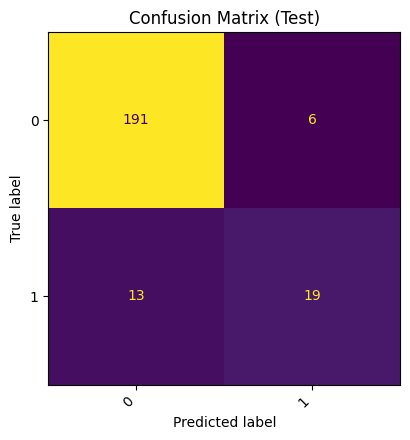

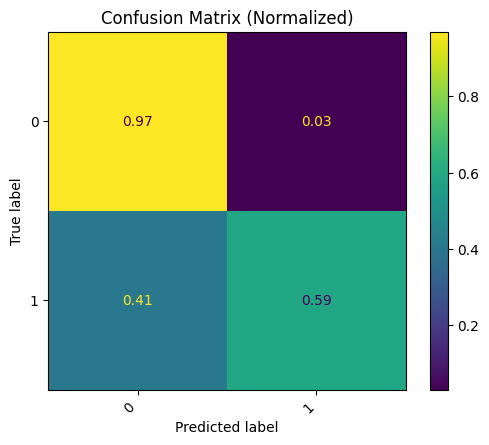

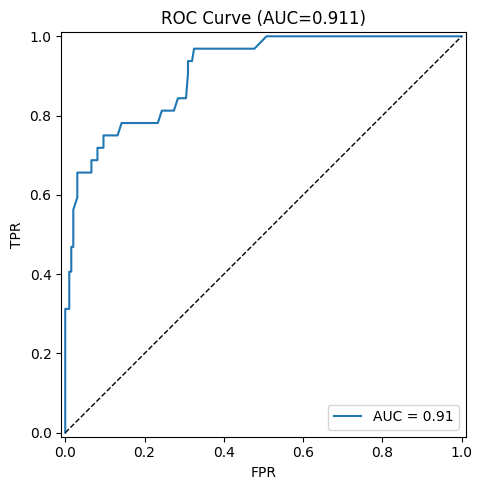

Saved baseline reports to: /home/shamil-suraweera/Documents/Horizon_Campus/IT41043-Intelligent_Systems/Assignment-1/mine/wine-quality-prediction/report


In [12]:
# 12) BASELINE CM/REPORT/ROC -> REPORT_DIR (CLASSIFICATION ONLY)
if TASK_TYPE.lower() != "classification":
    print("Skipping (regression).")
else:
    # Confusion matrix (counts)
    cm = confusion_matrix(y_test, best_pipe.predict(X_test))
    fig, ax = plt.subplots(figsize=(5.5,4.5))
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax, colorbar=False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_title("Confusion Matrix (Test)")
    plt.tight_layout()
    (REPORT_DIR/"confusion_matrix.png").resolve()
    plt.savefig(REPORT_DIR/"confusion_matrix.png", dpi=150); plt.show()

    # Normalized
    cmn = confusion_matrix(y_test, best_pipe.predict(X_test), normalize="true")
    fig, ax = plt.subplots(figsize=(5.5,4.5))
    ConfusionMatrixDisplay(confusion_matrix=cmn).plot(ax=ax, colorbar=True)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_title("Confusion Matrix (Normalized)")
    plt.tight_layout()
    plt.savefig(REPORT_DIR/"confusion_matrix_normalized.png", dpi=150); plt.show()

    # Classification report files
    rep = classification_report(y_test, best_pipe.predict(X_test), output_dict=True)
    pd.DataFrame(rep).T.to_csv(REPORT_DIR/"classification_report.csv")
    with open(REPORT_DIR/"classification_report.json","w") as f: json.dump(rep, f, indent=2)

    # ROC (if scores available)
    y_score = None
    try: y_score = best_pipe.predict_proba(X_test)
    except Exception:
        try: y_score = best_pipe.decision_function(X_test)
        except Exception: pass

    if y_score is not None:
        classes_sorted = np.unique(y_test)
        fig, ax = plt.subplots(figsize=(6,5))
        if len(classes_sorted)==2:
            scores_pos = y_score if y_score.ndim==1 else y_score[:,1]
            fpr, tpr, _ = roc_curve(y_test, scores_pos)
            roc_auc = auc(fpr, tpr)
            RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax)
            ax.set_title(f"ROC Curve (AUC={roc_auc:.3f})")
        else:
            from sklearn.preprocessing import label_binarize
            y_bin = label_binarize(y_test, classes=classes_sorted)
            for i, cls in enumerate(classes_sorted):
                fpr, tpr, _ = roc_curve(y_bin[:,i], y_score[:,i])
                ax.plot(fpr, tpr, label=f"Class {cls} (AUC={auc(fpr,tpr):.3f})")
            ax.legend(loc="lower right"); ax.set_title("ROC Curves (OvR)")
        ax.plot([0,1],[0,1],"k--",lw=1); ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
        plt.tight_layout(); plt.savefig(REPORT_DIR/"roc_curve.png", dpi=150); plt.show()

    print("Saved baseline reports to:", REPORT_DIR)


In [13]:
# 13) THRESHOLD TUNING (COMPUTE F1/F2) — CLASSIFICATION BINARY
assert TASK_TYPE.lower()=="classification", "Threshold tuning for classification only."
classes = np.unique(y_test); assert len(classes)==2, f"Binary required; got {len(classes)}"
pos_label = 1 if 1 in classes else classes.max()

# scores (proba preferred)
try:
    proba = best_pipe.predict_proba(X_test)
    model = getattr(best_pipe, "named_steps", {}).get("model", None)
    if model is not None and hasattr(model, "classes_"):
        col = list(model.classes_).index(pos_label)
    else:
        col = list(np.unique(y_train)).index(pos_label)
    y_score = proba[:, col]
except Exception:
    s = best_pipe.decision_function(X_test)
    y_score = s if s.ndim==1 else s[:, list(np.unique(y_train)).index(pos_label)]

# PR curve → thresholds
prec, rec, th = precision_recall_curve((y_test==pos_label).astype(int), y_score)
eps=1e-12
f1_vals = (2*prec*rec)/(prec+rec+eps)
beta=2.0
f2_vals = (1+beta**2)*(prec*rec)/(beta**2*prec+rec+eps)
best_f1_i = int(np.nanargmax(f1_vals[1:]))+1
best_f2_i = int(np.nanargmax(f2_vals[1:]))+1
t_f1 = float(th[best_f1_i-1]); t_f2 = float(th[best_f2_i-1])
print(f"Best F1 at t={t_f1:.3f} | prec={prec[best_f1_i]:.3f} rec={rec[best_f1_i]:.3f}")
print(f"Best F2 at t={t_f2:.3f} | prec={prec[best_f2_i]:.3f} rec={rec[best_f2_i]:.3f}")


Best F1 at t=0.472 | prec=0.778 rec=0.656
Best F2 at t=0.233 | prec=0.558 rec=0.750


In [ ]:
# 14) SAVE TUNED REPORTS (F1/F2) -> REPORTS_DIR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def _save_at_t(threshold, tag):
    y_hat = (y_score >= threshold).astype(int)

    # raw CM
    cm = confusion_matrix(y_test, y_hat, labels=classes)
    fig, ax = plt.subplots(figsize=(5.5,4.5))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(ax=ax, colorbar=False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_title(f"Confusion Matrix (t={threshold:.2f})")
    plt.tight_layout(); plt.savefig(REPORTS_DIR / f"confusion_matrix_t_{tag}.png", dpi=150); plt.close(fig)

    # normalized CM
    cmn = confusion_matrix(y_test, y_hat, labels=classes, normalize="true")
    fig, ax = plt.subplots(figsize=(5.5,4.5))
    ConfusionMatrixDisplay(confusion_matrix=cmn, display_labels=classes).plot(ax=ax, colorbar=True)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_title(f"Confusion Matrix (Normalized, t={threshold:.2f})")
    plt.tight_layout(); plt.savefig(REPORTS_DIR / f"confusion_matrix_normalized_t_{tag}.png", dpi=150); plt.close(fig)

    rep = classification_report(y_test, y_hat, output_dict=True)
    pd.DataFrame(rep).T.to_csv(REPORTS_DIR / f"classification_report_t_{tag}.csv")
    with open(REPORTS_DIR / f"classification_report_t_{tag}.json","w") as f: json.dump(rep, f, indent=2)

_save_at_t(t_f1, "F1")
_save_at_t(t_f2, "F2")

with open(REPORTS_DIR / "thresholds.json","w") as f:
    json.dump({"pos_label": int(pos_label), "best_F1":{"threshold": t_f1}, "best_F2":{"threshold": t_f2}}, f, indent=2)

print("Saved tuned reports & thresholds to:", REPORTS_DIR)


Saved tuned reports & thresholds to: /home/shamil-suraweera/Documents/Horizon_Campus/IT41043-Intelligent_Systems/Assignment-1/mine/wine-quality-prediction/report


In [15]:
# 15) SAVE MODEL ARTIFACTS -> /models
MODEL_PATH   = (ARTIFACTS_DIR / "model.pkl").resolve()
METRICS_PATH = (ARTIFACTS_DIR / "metrics.json").resolve()

dump(best_pipe, MODEL_PATH)
with open(METRICS_PATH, "w") as f: json.dump(test_metrics, f, indent=2)

# class map (classification only)
if TASK_TYPE.lower()=="classification":
    with open(ARTIFACTS_DIR/"class_map.json","w") as f:
        json.dump({"classes": sorted(np.unique(y_train).tolist())}, f, indent=2)

# feature names for app forms
try:
    feats = best_pipe.named_steps["prep"].get_feature_names_out().tolist()
except Exception:
    feats = list(X_train.columns)
with open(ARTIFACTS_DIR/"feature_names.json","w") as f:
    json.dump({"features": feats}, f, indent=2)

print("Saved:", MODEL_PATH)
print("Saved:", METRICS_PATH)


Saved: /home/shamil-suraweera/Documents/Horizon_Campus/IT41043-Intelligent_Systems/Assignment-1/mine/wine-quality-prediction/models/model.pkl
Saved: /home/shamil-suraweera/Documents/Horizon_Campus/IT41043-Intelligent_Systems/Assignment-1/mine/wine-quality-prediction/models/metrics.json


In [16]:
# 16) RELOAD SMOKE TEST
pipe_loaded = load(ARTIFACTS_DIR/"model.pkl")
print("Reload OK. Sample prediction:", pipe_loaded.predict(X_test.iloc[:1]))
print("Artifacts:", ARTIFACTS_DIR)
print("Reports  :", REPORT_DIR)


Reload OK. Sample prediction: [1]
Artifacts: /home/shamil-suraweera/Documents/Horizon_Campus/IT41043-Intelligent_Systems/Assignment-1/mine/wine-quality-prediction/models
Reports  : /home/shamil-suraweera/Documents/Horizon_Campus/IT41043-Intelligent_Systems/Assignment-1/mine/wine-quality-prediction/report
